In [88]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, models

### Load VGG19 model
First, we'd better to load the pretrained VGG19 model from ``torchvision.models``, which saves us lots of time of training the VGG19 from scratch.

VGG19 is split into two parts: 
* ``vgg19.features``, which are the convolutional and pooling layers
* ``vgg19.classifier``, which are the three linear and classifier layers

We just need to load the ``features`` portion.

In [3]:
# load features of vgg19 from torchvision models
vgg19_model = models.vgg19(pretrained = True).features

for param in vgg19_model.parameters():
    param.requires_grad_(False)

# move vgg19 model to GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19_model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Load and Transform Images

In [65]:
def load_image(img_path, shape=None, max_size=800):
    '''
    Load in and transform the target image defined by img_path
    '''
    
    image = Image.open(img_path)
    ### .convert('RGB')?
    
    if shape is not None:
        size = shape
    else:
        if max(image.size) > max_size:
            size = max_size
        else:
            size = max(image.size)
    
    img_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    
    image = img_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [73]:
content = load_image('images/architecture.jpg').to(device)
style = load_image('images/theStarryNight.jpg',shape=content.shape[-2:]).to(device)

print("content size: "+str(content.size()))
print("style size: "+str(style.size()))

content size: torch.Size([1, 3, 800, 1199])
style size: torch.Size([1, 3, 800, 1199])


In [86]:
def restore_image(tensor):
    '''
    Convert a Tensor image to NumPy image for display
    '''
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image.clip(0,1)
    
    return image

In [87]:
restore_image(content)

array([[[0.7254902 , 0.80784315, 0.92941177],
        [0.7294118 , 0.8117647 , 0.93333334],
        [0.7254902 , 0.80784315, 0.92941177],
        ...,
        [0.5019608 , 0.6117647 , 0.8156863 ],
        [0.49411765, 0.60784316, 0.8117647 ],
        [0.49411765, 0.60784316, 0.8117647 ]],

       [[0.7294118 , 0.8117647 , 0.93333334],
        [0.7294118 , 0.8117647 , 0.93333334],
        [0.7254902 , 0.80784315, 0.92941177],
        ...,
        [0.49411765, 0.6039216 , 0.8117647 ],
        [0.49019608, 0.6039216 , 0.80784315],
        [0.49411765, 0.6117647 , 0.8156863 ]],

       [[0.7294118 , 0.8117647 , 0.93333334],
        [0.7294118 , 0.8117647 , 0.93333334],
        [0.7254902 , 0.80784315, 0.92941177],
        ...,
        [0.49411765, 0.6039216 , 0.8156863 ],
        [0.49411765, 0.6       , 0.8117647 ],
        [0.49411765, 0.6039216 , 0.8117647 ]],

       ...,

       [[0.3372549 , 0.5882353 , 0.7254902 ],
        [0.3372549 , 0.58431375, 0.7254902 ],
        [0.32156864, 0

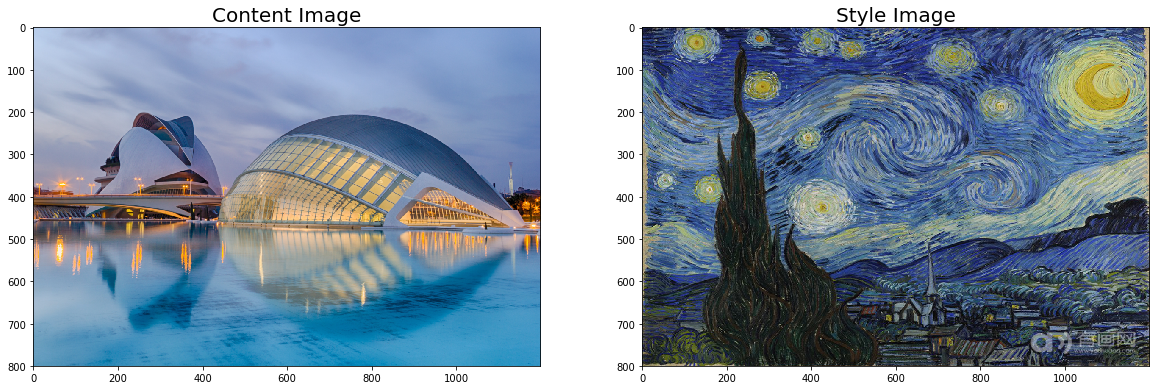

In [99]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title("Content Image",fontsize = 20)
ax1.imshow(restore_image(content))
ax2.set_title("Style Image",fontsize = 20)
ax2.imshow(restore_image(style))